## INFO284 - Group exam

Your tasks are:

#### Preprocessing: 
Get to understand the data and remove columns and rows that you do not find useful for your machine learning models. It is possible to for example focus on one type of gear, one or a few species, group categories of species, etc. etc. This will help to reduce
the data set you are working on. Understanding data and preparing them for model building
is a main task of machine learning.

#### Supervised learning: 
Build at least three machine learning models to predict or classify catch
data related to a fishery operation, i.e. species caught, amounts of one fish species (sums of amounts is also possible), or other features related to fish catches. One of the models needs to be a deep learning model.

#### Unsupervised learning: 
Build a clustering model for the data set. You may use a different preprocessing for this task than for the data in task b).


You shall deliver code in the form of a well commented Jupyter notebook. This code needs to run on the original data set, so any preprocessing you choose to do needs to be programmed in Python and included in the notebook. The code shall in the end return the results of your experiments with your chosen models. You need to explain

- Important and relevant properties of the data
- how you preprocessed data like which features you selected, did you do dimension reduction 
- how you reformatted data, etc.
- how you decided on parameters for your machine learning models,
- if you used any regularization techniques? In case how.
- how the methods were measured and compared

Please inform about any special Python libraries that need to be installed to make your code runnable.

Finally, as a concluding comment in the Jupyter notebook, you need to write a summary of your results, and discuss consequences of such results.

It is not necessarily so that high scores for machine learning models will give a good grade on your report, or vice versa, low scores a bad grade. What counts is a well-argued, well described, and smart machine learning investigation from start to end. The problem may in fact be of such nature that it is not possible to get really good results on these data.
Final note: These data are prepared for this course and are shared with you in confidence that you do not share them in any way but use them only for the purpose of this exam.


# 1: Preprocessing


## 1: Importerer nødvendige biblioteker
Legge inn en kort analyse av csv-filen
Leser csv.

In [268]:
import pandas as pd
import numpy as np
from sklearn import linear_model  # For den lineære modellen.
from sklearn.model_selection import train_test_split  # For å splitte datasettet.
import datetime as dt
import matplotlib.pyplot as plt  # For statistikk og grafiske fremstillinger.
import seaborn as sns  # For statistikk og grafiske fremstillinger
from sklearn.tree import DecisionTreeRegressor
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler  # For å skalere

from sklearn.metrics import mean_squared_error # For å måle resultat

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV

df = pd.read_csv("GroupExam2024_data_and_documentation/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')

## 2: Splitte datasett
Legge inn litt om hvorfor

In [269]:
# Splitter datasettet i train_df og test_df
train_df, test_df = train_test_split(df, test_size = 0.15)

## 3: Utforske datasettet:
Skrive litt om hva vi tenker å gjøre?

In [270]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259618 entries, 66502 to 193718
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                259618 non-null  int64  
 1   Meldingstidspunkt         259618 non-null  object 
 2   Meldingsdato              259618 non-null  object 
 3   Meldingsklokkeslett       259618 non-null  object 
 4   Starttidspunkt            259618 non-null  object 
 5   Startdato                 259618 non-null  object 
 6   Startklokkeslett          259618 non-null  object 
 7   Startposisjon bredde      259618 non-null  float64
 8   Startposisjon lengde      259618 non-null  float64
 9   Hovedområde start (kode)  257905 non-null  float64
 10  Hovedområde start         256065 non-null  object 
 11  Lokasjon start (kode)     257905 non-null  float64
 12  Havdybde start            259618 non-null  int64  
 13  Stopptidspunkt            259618 non-null  ob

Av df.info ser vi de ulike kolonnene og hvilken datatype de er. og hvor mange "non-null" verdier som eksisterer. Kan se her at det eksisterer null-verdier i de fleste kolonner. Dette renses senere. Konverterer datatype etter å ha filtrert ut de uaktuelle kolonnene.

Basert på datasettet og kolonnene vi har sett på så ønsker vi å predikere rundvekt av en aktivitet.


Ser av datasettet hvordan dataen er strukturert. 
**Organisering av datasettet**
Hver rad representerer en fangst av art. Flere rader er registrert med samme starttidspunkt eller stopptidspunkt. De ulike fangstene som er gjort på samme tidspunkt med samme melding ID kommer fra samme fiskeaktivitet. Videre så har de ulike aktivitetene som er gjort på samme Melding ID samme meldingsdato, og kommer fra samme båt.

**Bruttotonnasje 1969 og Bruttotonnasje annen**
Vi ser også at kolonnen Bruttotonnasje annen og bruttotonnasje 1969 ser ut til å utfylle hverandre.Med bruttotonnasje menes det totale volumet av hulrom i båten. Det kan ikke helt sammenlignes med lastekapasitet, men kan være en indikator. Bruttotonnasje 1969 er standarden i dag for registrering av dette målet av båten. Bruttotonnasje annen viser de båtene som er registrert gjennom andre systemer enn standarden.

Vi antar at selv om det antakelig er forskjeller i hvordan disse båtene har målt sin Bruttotonnasje, så er det sannsynligvis også så mange likheter at det ikke har betydning. Dette er det kanskje nødvendig å undersøke nermere dersom man vil ha en mer nøyaktig analyse av dataene. Disse to kolonnene vil vi derfor slå sammen. til en felles kolonne.

Hva leter vi etter?
Siden dette er en samling av fiskeridata, så tenker vi det er interessant å se nærmere på fangstdataene. Her kunne vi hatt mange interessante innfallsvinkler, men vi ønsker å se om det er mulig å predikere rundvekt av en bestemt art gitt den informasjonen vi har. Siden fiskere bruker ulike redskaper for å fange fisk kan vi kan anta at noen redskaper og metoder er mer egnet for å fange bestemte arter. For eksempel så brukes ikke teiner for å fange torsk eller trål for å fange makrell (Må sjekke opp i). I tillegg vet vi også at det foregår fiske etter ulike arter på ulike steder og tidspunkt. Skreifiske for eksempel foregår i bestemte tidsrom etter bestemte arter, med bestemte redskaper. Videre kan vi anta at det samme gjelder for for eksempel sildefiske. Kunnskap om hvordan, hvor og hva som fiskes etter er derfor viktig for å forstå datasettet. Videre avsnitt bruker vi på å undersøke informasjon omkring fisket.


In [271]:
# Først undersøker vi hvor mange registreringer det er av de ulike fisketypene og hvor mye det fiskes av hver.

species_weight_sum = train_df.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Art - gruppe'].value_counts())
print(species_weight_sum)

Art - gruppe
Torsk                                       47917
Annen torskefisk                            38514
Sei                                         36187
Hyse                                        33346
Annen flatfisk, bunnfisk og dypvannsfisk    21479
Uer                                         16819
Steinbiter                                  13760
Dypvannsreke                                11575
Blåkveite                                    6764
Snøkrabbe                                    5169
Sild, annen                                  5104
Skater og annen bruskfisk                    3453
Makrell                                      2556
Kolmule                                      2457
Øyepål                                       1901
Annen pelagisk fisk                          1524
Vassild og strømsild                         1395
Andre skalldyr, bløtdyr og pigghuder         1137
Lodde                                        1017
Tobis og annen sil                   

Her ser vi en hovedvekt av fiske etter Torsk. På en annenplass kommer sei. Reke er det også mye aktivitet rundt.

In [272]:
# Gjør samme undersøkelse av reskaper.

redskap_weight_sum = train_df.groupby('Redskap FDIR')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Redskap FDIR'].value_counts())
print(redskap_weight_sum)

Redskap FDIR
Bunntrål                                  102448
Snurrevad                                  43888
Andre liner                                37359
Reketrål                                   19125
Udefinert garn                             16404
Udefinert trål                             13395
Snurpenot/ringnot                          10792
Teiner                                      5811
Bunntrål par                                2805
Dobbeltrål                                  2427
Flytetrål                                   2336
Flytetrål par                               1313
Settegarn                                    533
Harpun og lignende uspesifiserte typer       404
Annet                                        387
Juksa/pilk                                    17
Dorg/harp/snik                                15
Name: count, dtype: int64
Redskap FDIR
Snurpenot/ringnot                         663876609.0
Flytetrål                                 404381819.0
Bunntrå

Her ser vi at de to mest brukte fangstredskapene er Bunntrål og Snurrevad. Videre er andre liner, reketrål og andre liner høyt oppe på listen. fra fiskeridirektoratet (kilde) vet vi at Bunntrål og Snurrevad er garn/not som blir slept langs bunnen av sjøen og samler opp fisk på den måten. Andre liner (dersom vi har forstått det riktig) er fiske med agn og krok som kan settes ut.

Vi velger å fokusere videre på Bunntrål og snurrevad, siden vi har mye data på disse, og de har noe lik fangstmetodikk.

Vi ser videre på sammensetningen av fisk med disse to metodene. 

In [273]:
# Ser etter hvilke fisk som blir fisket med Bunntrål:
condition = train_df[train_df['Redskap FDIR'] == 'Bunntrål']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       19833
Sei                                         15524
Hyse                                        14206
Annen torskefisk                            12671
Uer                                         12191
Annen flatfisk, bunnfisk og dypvannsfisk     7324
Dypvannsreke                                 6305
Steinbiter                                   6171
Blåkveite                                    4296
Skater og annen bruskfisk                     680
Øyepål                                        619
Andre skalldyr, bløtdyr og pigghuder          525
Kolmule                                       426
Vassild og strømsild                          400
Annen pelagisk fisk                           343
Sild, annen                                   279
Makrell                                       199
Tobis og annen sil                            159
Haifisk                                        57
Lodde                                

In [274]:
# Ser etter hvilke fisk som blir fisket med Snurrevad:
condition = train_df[train_df['Redskap FDIR'] == 'Snurrevad']

species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       13849
Hyse                                        10172
Sei                                          9608
Annen flatfisk, bunnfisk og dypvannsfisk     3566
Annen torskefisk                             3479
Steinbiter                                   1092
Uer                                           707
Blåkveite                                     303
Sild, annen                                    25
Makrell                                        21
Skater og annen bruskfisk                      10
Lodde                                           9
Dypvannsreke                                    8
Andre skalldyr, bløtdyr og pigghuder            4
Haifisk                                         4
Annen pelagisk fisk                             1
Sjøpattedyr                                     1
Name: count, dtype: int64 Art - gruppe
Torsk                                       49463718.0
Sei                                        

Etter å ha studert de ulike redskapene og hva som blir fisket med de aktuelle, ser vi også konturene av hvordan de blir brukt. Bunntrål er den mest ukritiske fangstmetoden og den tar med seg et større mangfold av fisk enn for eksempel snurrevad som kanskje er naturlig å sammenligne med. Man skulle tro av navnet at en reketrål var mer målrettet i fangsten, og at andelen reker var større i denne sammensetningen, men her kan vi også anta, at siden reker står ganske lavt i næringskjeden, så vil det være naturlig at det er en stor andel av "rovfisker" i miksen. Vi har ikke sett her hvor stor andel av vekten de andre fiskene utgjør

Redskaper:
    Snurpenot/ringnot:
        Dette er det redskapet som det blir fisket desidert mest fisk med, selv om det er mye flere registreringer av andre redskaper. Forklaring her kan være at at med Snurpenot/ringnot blir det fisket mest stimfisk som sild, lodde, makrell osv, som opptrer i stim og dermed er naturlig at man fanger mye av når man først har funnet stimen. Det trenger ikke nødvendigvis bety at det er et mer effektivt fiske.
    Bunntrål:
        Med dette redskapet blir det fisket mest torsk og sei, men også ganske mye av andre arter. Det er det redskapet som vi har undersøkt som har jevnest fordeling arter, som betyr at det er det redskapet som bidrar med mest bifangst.
    Snurrevad:
        Dette redskapet ligner på bunntrål, men det virker som det drives litt mer målrettet fiske med dette. Spredningen av fangst av forskjellige arter er ikke så stor.
    Andre liner:
    Reketrål:
    
Basert på denne infoen er det interessant å dykke videre inn i et bestemt redskap og art og muligens et bestemt område. 


In [275]:
print(train_df['Hovedområde start'].value_counts())

Hovedområde start
Eigersundbanken                  38505
Røstbanken til Malangsgrunnen    24839
Vest-Finnmark                    23462
Øst-Finnmark                     22988
Bjørnøya                         21464
Shetland                         21190
Nordkappbanken                   15849
Vikingbanken                     14026
Skagerrak                        13672
Storegga-Frøyabanken             12672
Helgelandsbanken                  7265
Sentralbanken                     4747
Storbanken                        4100
Thor Iversens Bank                3820
Vestfjorden (Lofoten)             3817
Sentrale Nordsjø                  2883
Hopen                             2660
Vest av Skottland (Hebridene)     1739
Sørlige Norskehav                 1653
Østlige Norskehav                 1634
Skolpenbanken                     1628
Admiralityfeltet                  1601
Gåsebanken                        1440
Storfjord/Hinlopenstredet         1157
Vest-Spitsbergen                  1039
Vest av

### Konklusjon av første titt på data:
Hva leter vi etter:
Vi ønsker å prøve ut forskjellige maskinlæringsmodeller for å predikere fangst av en bestemt type fisk. Ut fra det vi har sett av data har ønsker vi å filtrere ut data etter følgende betingelser: fangstredskap - Trål, Hovedart - Sei, Område - Norskekysten

Art:
Vi har valgt å fokusere på seifiske, siden dette er en av de fiskene som blir fisket hyppigst i Norge i dag.

Lokasjon:
I Norge er det hovedsaklig fiske etter to grupper av sei. En gruppe som beiter i havområdene mellom Norge og Skottland https://www.hi.no/hi/temasider/arter/sei-i-nordsjoen og en annen som beiter i kystområdene fra vestlandet til finnmark. https://www.hi.no/hi/temasider/arter/nordaustarktisk-sei.
Vi ønsker å fokusere på den nordøstarktiske seien, kan det se ut fra denne informasjon at det kan være lurt å fokusere på hovedområdene fra 0-7 og 28 men uten hovedområde 2. Om vi skal inkludere Nordsjøseien, så kan vi inkludere områdene 40-43, men da beveger vi oss også litt utenfor de de norske områdene.

Redskap:
Siden det eksisterer et så stort omfang av trålfiske, så eksisterer det også mye data. Trål er også det redskapet som er mest brukt for å fiske sei.

For å finne de aktuelle hovedområdene, benytter vi oss av karttjenesten til fiskeridirektoratet.
https://open-data-fiskeridirektoratet-fiskeridir.hub.arcgis.com/datasets/1b8c3425aaf643e9b2abd3bc70111697/explore 



## 4: Filtrere data:

In [276]:
# Lager en betingelse med aktuelle områder.
northeastern = [0, 1, 3, 4, 5, 6, 7, 28]
northeastern_ocean = [30, 34, 37, 39, 12, 36] # For å undersøke om det er noe særlig seifiske utenfor de mer kystnære strøk
northsea = [40, 41, 42, 43] # For å undersøke seifiske
# Legger inn betingelser i train_df.
filtered_train_df = train_df[
    (train_df['Hovedart FAO'] == 'Sei') &
    (train_df['Hovedområde start (kode)'].isin(northeastern)) &
    (train_df['Redskap FDIR'] == 'Bunntrål')
]

# Gjør det samme med test-settet
filtered_test_df = test_df[
    (test_df['Hovedart FAO'] == 'Sei') &
    (test_df['Hovedområde start (kode)'].isin(northeastern)) &
    (test_df['Redskap FDIR'] == 'Bunntrål')
]

filtered_train_df.describe()  # Får her et inntrykk av ekstremverdier og gjennomsnitt.

Melding ID  Startposisjon bredde  Startposisjon lengde  \
count  2.300000e+04          23000.000000          23000.000000   
mean   1.646175e+06             66.700179             12.978637   
std    9.435170e+04              4.126490              8.345674   
min    1.497435e+06             60.001000              2.006000   
25%    1.549221e+06             62.834000              5.322000   
50%    1.664653e+06             67.981000             10.820000   
75%    1.728907e+06             70.864000             20.557000   
max    1.800286e+06             71.998000             32.279000   

       Hovedområde start (kode)  Lokasjon start (kode)  Havdybde start  \
count              23000.000000           23000.000000    23000.000000   
mean                   8.623913              19.146609     -188.962478   
std                    8.318377              13.907607       65.084010   
min                    0.000000               1.000000     -761.000000   
25%                    4.000000               9.000000     -226.000000   
50%                    5.000000              15.000000     -183.000000   
75%                    7.000000              23.000000     -145.000000   
max                   28.000000              54.000000        1.000000   

           Varighet  Fangstår  Stopposisjon bredde  Stopposisjon lengde  ...  \
count  23000.000000   23000.0         23000.000000         23000.000000  ...   
mean     255.399304    2018.0            66.716460            13.012397  ...   
std       89.346665       0.0             4.137136             8.364591  ...   
min        6.000000    2018.0            59.647000             1.654000  ...   
25%      195.000000    2018.0            62.836000             5.335000  ...   
50%      267.000000    2018.0            67.986500            10.885000  ...   
75%      320.000000    2018.0            70.879000            20.585000  ...   
max     1706.000000    2018.0            72.060000            32.226000  ...   

       Redskap FDIR (kode)  Hovedart - FDIR (kode)  Art - FDIR (kode)  \
count              23000.0                 23000.0       23000.000000   
mean                  51.0                  1032.0        1237.213087   
std                    0.0                     0.0         453.745458   
min                   51.0                  1032.0         529.000000   
25%                   51.0                  1032.0        1023.000000   
50%                   51.0                  1032.0        1032.000000   
75%                   51.0                  1032.0        1034.000000   
max                   51.0                  1032.0        2919.000000   

       Art - gruppe (kode)      Rundvekt  Lengdegruppe (kode)  \
count         23000.000000  23000.000000         23000.000000   
mean            225.154565   2669.395609             4.934217   
std              39.893340   5335.770450             0.286474   
min             201.000000      0.000000             3.000000   
25%             202.000000     77.000000             5.000000   
50%             203.000000    260.000000             5.000000   
75%             220.000000   2394.000000             5.000000   
max             520.000000  66334.000000             5.000000   

       Bruttotonnasje 1969  Bruttotonnasje annen        Bredde  Fartøylengde  
count         22290.000000            710.000000  23000.000000  23000.000000  
mean           1947.416196            165.625352     12.896732     57.123429  
std            1077.490288             16.446277      2.272176     15.222972  
min             197.000000            129.000000      7.000000     19.750000  
25%            1199.000000            173.000000     12.000000     50.800000  
50%            1598.000000            173.000000     13.000000     56.800000  
75%            2610.000000            173.000000     14.600000     69.900000  
max            4427.000000            173.000000     16.700000     81.200000  

[8 rows x 24 columns]

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


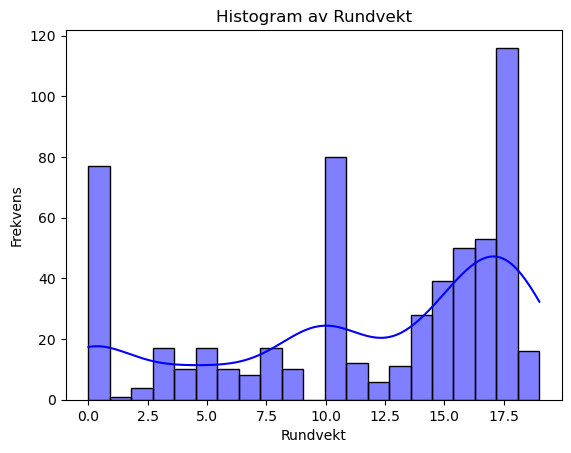

In [277]:
rundvekt = filtered_train_df[filtered_train_df['Rundvekt']< 20]
sns.histplot(rundvekt['Rundvekt'], kde=True, bins=21, color='blue')
plt.title('Histogram av Rundvekt')
plt.xlabel('Rundvekt')
plt.ylabel('Frekvens')
plt.show()

## 5: Gruppere data og fjerne noen kolonner:
Vi har valgt å gruppere data etter aktiviteter etter å ha sett igjennom data først. Man kan argumentere for at det ville vært lurt å gjort det før i prosjektet, men mulige utfordringer da er å ikke kunne fange opp nyansene i datasettet. 

For eksempel så er det slik at på en aktivitet så er det registrert flere arter og rundvekt av hver art. Dersom man ikke har et bilde av hvordan fordelingen av rundvekt er, så kan man senere få utfordringer med modellen. Vi er bevisst på at når vi slår disse aktivitetene sammen, så beregner vi også rundvekten for hele fangsten ikke bare rundvekten av hovedarten.

Vi gjør derfor en antakelse om at rundvekt gir oss en pekepinn på hva en god fangst er, uavhengig av hvilke arter som er fanget, selv om vi ikke vet helt sikkert at det er slik. Kanskje er målrettet fiske mer lønnsomt. Men når man fisker med trål så er mangfoldet av arter som man fanger en del av bildet.

Skal man predikere fangst basert på redskapet trål, så blir det, gitt omfanget av oppgaven, naturlig å regne rundvekt basert på hele fangsten, men med fokus på en bestemt art.



In [278]:
# Funksjon for å samle de sammenslåtte dataene som tekststreng.
def join_unique_values(series):
    return ', '.join(series.dropna().astype(str).unique())

grouped_df = filtered_train_df.groupby(['Melding ID', 'Meldingstidspunkt'], as_index=False).agg({
    'Melding ID': 'first', # Trengs muligens for å skille aktiviterer fra ulike båter.
    'Meldingstidspunkt': 'first', 
    'Meldingsdato': 'first',
    'Meldingsklokkeslett': 'first', 
    'Starttidspunkt': 'first', 
    'Startdato': 'first',
    'Startklokkeslett': 'first', 
    'Startposisjon bredde': 'first', 
    'Startposisjon lengde': 'first',
    'Hovedområde start (kode)': 'first', 
    #'Hovedområde start': 'first',  # Vi forholder oss til koden, da blir denne kolonnen irrelevant
    #'Lokasjon start (kode)': 'first', # Mye tomme celler, dokumentasjonen advarer om å bruke denne kolonnen.
    'Havdybde start': 'first', 
    'Stopptidspunkt': 'first', 
    'Stoppdato': 'first', 
    'Stoppklokkeslett': 'first', 
    'Varighet': 'first', 
    #'Fangstår': 'first', Så og si alle fangstdata er registrert i 2018.
    'Stopposisjon bredde': 'first', 
    'Stopposisjon lengde': 'first',
    # 'Hovedområde stopp (kode)': 'first', # Vi forholder oss til området hvor fisket starter. 
    #'Hovedområde stopp': 'first', 
    #'Lokasjon stopp (kode)': 'first', # Unødvendig å ha med videre.
    'Havdybde stopp': 'first', 
    'Trekkavstand': 'first',
    #'Redskap FAO (kode)': 'first', # Unødvendig med flere kolonner av redskaper
    #'Redskap FAO': 'first', 
    #'Redskap FDIR (kode)': 'first',
    'Redskap FDIR': 'first', # Vi forholder oss FDIR sine kolonner av redskaper.
    #'Hovedart FAO (kode)': 'first', 
    'Hovedart FAO': 'first',
    #'Hovedart - FDIR (kode)': 'first', 
    #'Art FAO (kode)': join_unique_values, # Sletter bifangst radene, siden vi ikke er interessert i å se på bifangst. 
    #'Art FAO': join_unique_values,
    #'Art - FDIR (kode)': join_unique_values, 
    #'Art - FDIR': join_unique_values, 
    #'Art - gruppe (kode)': 
    #'Art - gruppe': 'Join_unique_values' 
    'Rundvekt': 'sum', # Summerer sammen fangsten på en aktivitet.
    'Lengdegruppe (kode)': 'first', 
    'Lengdegruppe': 'first',
    'Bruttotonnasje 1969': 'first', 
    'Bruttotonnasje annen': 'first', 
    'Bredde': 'first',
    'Fartøylengde': 'first'
    })

grouped_df.head()

Melding ID Meldingstidspunkt Meldingsdato Meldingsklokkeslett  \
0     1497435  02.01.2018 07:50   02.01.2018               07:50   
1     1497823  02.01.2018 23:31   02.01.2018               23:31   
2     1497827  02.01.2018 23:31   02.01.2018               23:31   
3     1497843  02.01.2018 23:45   02.01.2018               23:45   
4     1497856  02.01.2018 23:54   02.01.2018               23:54   

     Starttidspunkt   Startdato Startklokkeslett  Startposisjon bredde  \
0  01.01.2018 03:21  01.01.2018            03:21                68.256   
1  02.01.2018 00:20  02.01.2018            00:20                68.535   
2  02.01.2018 21:48  02.01.2018            21:48                69.483   
3  02.01.2018 16:52  02.01.2018            16:52                63.122   
4  02.01.2018 12:00  02.01.2018            12:00                61.221   

   Startposisjon lengde  Hovedområde start (kode)  ...  Trekkavstand  \
0                10.828                       5.0  ...       43775.0   
1                11.986                       5.0  ...       35125.0   
2                15.850                       5.0  ...        4006.0   
3                 5.381                       7.0  ...       34192.0   
4                 2.181                      28.0  ...       36931.0   

  Redskap FDIR Hovedart FAO Rundvekt  Lengdegruppe (kode)  Lengdegruppe  \
0     Bunntrål          Sei  18812.0                  5.0  28 m og over   
1     Bunntrål          Sei  17099.0                  5.0  28 m og over   
2     Bunntrål          Sei   5140.0                  4.0    21-27,99 m   
3     Bunntrål          Sei   1685.0                  5.0  28 m og over   
4     Bunntrål          Sei  24100.0                  5.0  28 m og over   

   Bruttotonnasje 1969  Bruttotonnasje annen  Bredde Fartøylengde  
0               2580.0                   NaN   14.60        64.00  
1               2580.0                   NaN   14.60        64.00  
2                  NaN                 129.0    7.01        25.07  
3                536.0                   NaN   10.30        33.95  
4               2053.0                   NaN   13.00        75.50  

[5 rows x 28 columns]

## 6: Utforske datasettet på nytt

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


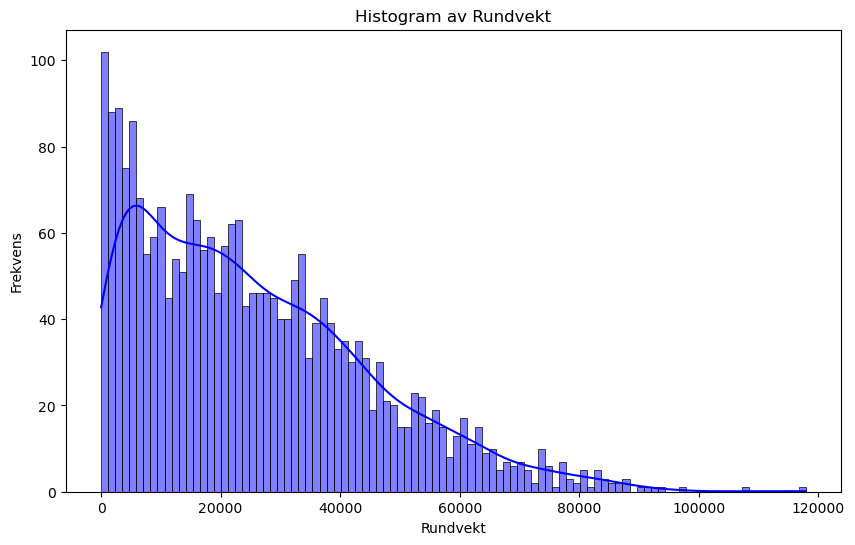

In [279]:
import seaborn as sns

# Ser på fordelingen av rundvekt.
plt.figure(figsize=(10, 6))
sns.histplot(grouped_df['Rundvekt'], kde=True, bins=100, color='blue')
plt.title('Histogram av Rundvekt')
plt.xlabel('Rundvekt')
plt.ylabel('Frekvens')
plt.show()

Ser her en interessant skeivhet i datasettet. Dette viser at det eksisterer veldig mange "bomturer" - Vi kan vurdere å konvertere datasettet til 

### Bruttotonnasje:
"Bruttotonn er totalvolumet av alle lukkede rom som er i bruk på et skip." (https://snl.no/bruttotonn) Ideellt i denne oppgaven skulle vi gjerne hatt en kolonne med nettotonn, siden det er skipets lastekapasitet. Det er vanskelig å vite hvilke mål på skipet som er de beste for å anslå skipets lastekapasitet, men vi har landet på bruttotonnasje som det beste målet. 

For å bruke bruttotonnasje-kolonnene er vi nødt til å kombinere kolonnene "bruttotonnasje 1969" og "bruttotonnasje annen". I dokumentasjonen står det følgende om bruttotonnasje 1969:

I denne variabelen, «Bruttotonnasje 1969», er det i dag ført bruttotonnasje for fartøy med 
lengde (L) større eller lik 24 meter (L), målt og berekna i medhald av internasjonal 
konvensjon om måling av fartøy, 1969 (London-konvensjonen 1969).

dvs at skip under 24 m er ført i bruttotonnasje annen og de andre i 1969. Vi kan da trygt slå sammen kolonnene siden ingen er registrert på forskjellige måter.

In [280]:
# Slår sammen bruttotonnasje-gruppene.
grouped_df.loc[:, 'Bruttotonnasje kombinert'] = grouped_df['Bruttotonnasje 1969'].fillna(grouped_df['Bruttotonnasje annen'])

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


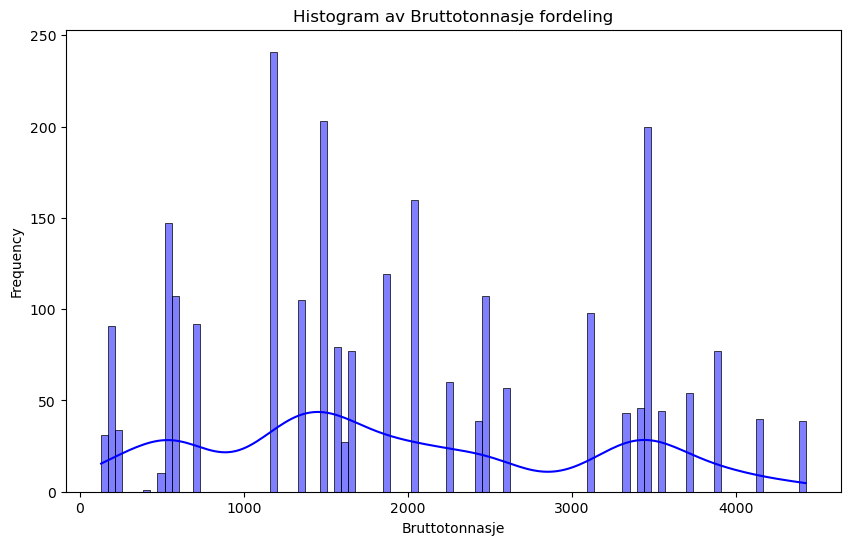

In [281]:
# Lager grafisk fremstilling av fordeling av båtstørrelse
plt.figure(figsize=(10, 6))
sns.histplot(grouped_df['Bruttotonnasje kombinert'], kde=True, bins=100, color='blue')
plt.title('Histogram av Bruttotonnasje fordeling')
plt.xlabel('Bruttotonnasje')
plt.ylabel('Frequency')
plt.show()

Ser her tendenser av at båtstørrelsen deles grovt inn i tre kategorier: Småbåter under 1000 bruttotonn, mellom store mellom 1000 og 3000 og store over 3000. vi velger å gruppere båtene inn i disse tre gruppene.

In [282]:
# Grupperer Bruttotonnasje-kolonnen
bins = [0, 1000, 2000, 3000, 4000]
labels = [1, 2, 3, 4]
grouped_df['Bruttotonnasje gruppert'] = pd.cut(grouped_df['Bruttotonnasje kombinert'], bins=bins, labels=labels)

grouped_df['Bruttotonnasje gruppert'].value_counts()

Bruttotonnasje gruppert
2    851
4    562
1    513
3    423
Name: count, dtype: int64

### Valg av kolonne i forhold til tid:
Etter å ha testet de ulike kolonnene hva gjelder fordeling av tid, ser vi at det er veldig mange registreringer på startklokkeslett 00.00


In [283]:
# Grupperer startklokkeslett i grupper etter timer slik at.
grouped_df['Startklokkeslett'] = pd.to_datetime(grouped_df['Startklokkeslett'], format='%H:%M')
grouped_df['Hours'] = grouped_df['Startklokkeslett'].dt.hour
print(grouped_df['Hours'].value_counts())

# Grupperer meldingsdato etter måneder.
grouped_df['Meldingsdato'] = pd.to_datetime(grouped_df['Meldingsdato'], format='%d.%m.%Y', errors='coerce')
grouped_df['Month'] = grouped_df['Meldingsdato'].dt.month
print(grouped_df['Month'].value_counts())

Hours
23    127
5     125
6     121
22    112
17    112
10    110
7     110
0     110
3     103
13    102
15     96
18     96
12     96
20     96
19     96
4      95
2      95
16     95
21     93
14     90
9      90
11     89
1      87
8      82
Name: count, dtype: int64
Month
3     326
2     313
9     220
7     219
4     200
1     186
12    181
11    176
6     175
8     155
5     149
10    128
Name: count, dtype: int64


Sjekker månedlig fagst av sei i områdene

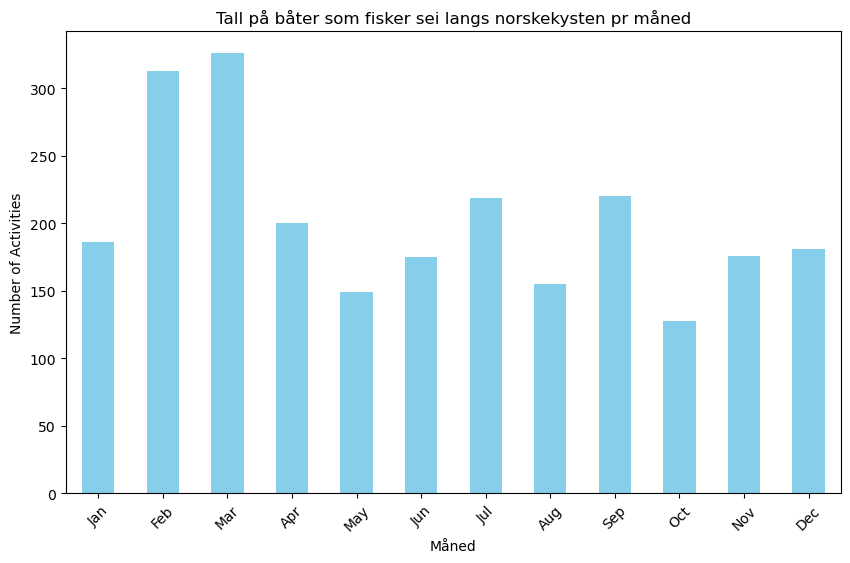

In [284]:
# Teller månedlig aktivitet.
monthly_counts = grouped_df.groupby('Month').size()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr måned')
plt.xlabel('Måned')
plt.ylabel('Number of Activities')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()


### aktiviteter pr måned
Vi ser her at det er mer aktivitet rundt seifiske i månedene februar og mars langs norskekysten. Det kan tenkes at dette har sammenheng med lofotfisket som foregår i månedene februar - april. 

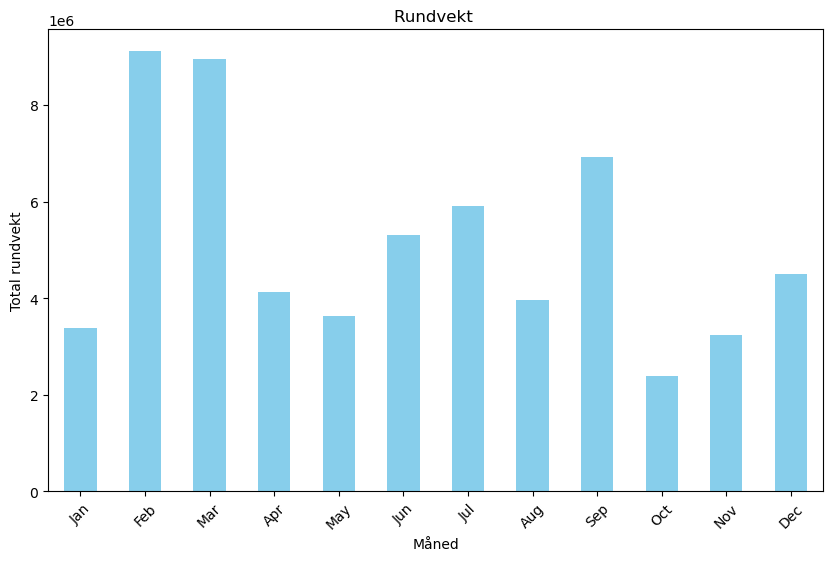

In [285]:
# Finner månedlig total rundvekt
monthly_weights = grouped_df.groupby('Month')['Rundvekt'].sum()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Rundvekt ')
plt.xlabel('Måned')
plt.ylabel('Total rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

### Samlet rundvekt av aktivitetene pr måned
Her ser vi tydelig sammenheng mellom månedene med stor aktivitet og den samlede rundvekten av aktivitetene.

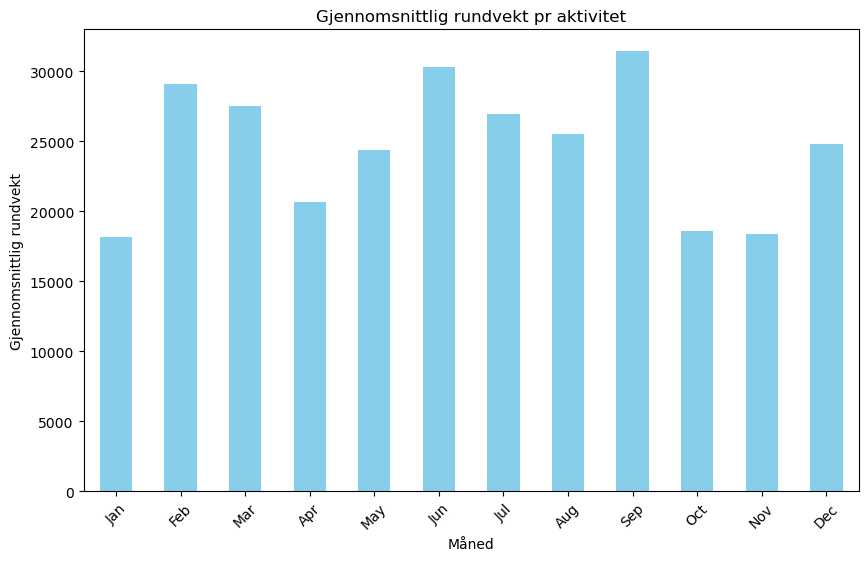

In [286]:
# Regner ut gjenomsnitt pr time
average_weights = monthly_weights/monthly_counts

# Oppretter en serie for alle timene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(average_weights.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr aktivitet')
plt.xlabel('Måned')
plt.ylabel('Gjennomsnittlig rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

Ser her av gjennomsnittlig vekt at seifiske virker å være stabilt i den forstand at den forventede fangsten holder seg ganske stabil gjennom året.
September utmerker seg likevel som en måned hvor det er er forventet mer fisk.

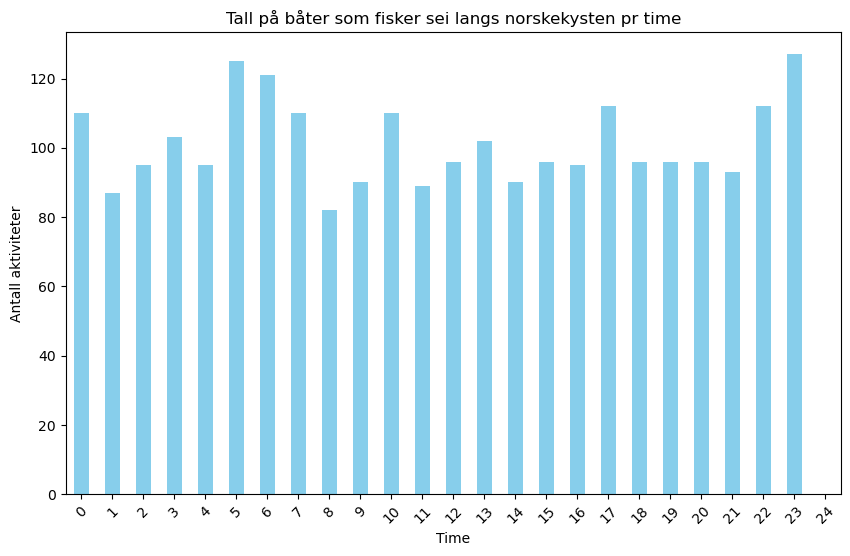

In [287]:
# Regner ut gjenomsnitt pr time
hourly_counts = grouped_df.groupby('Hours').size()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr time')
plt.xlabel('Time')
plt.ylabel('Antall aktiviteter')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()


Her ser vi hvordan fiskeaktivitetene av sei varierer i løpet av døgnet. Ser at det er en nokså stabil aktivitet gjennom døgnet. Her hadde vi forventet litt variasjoner.

Det er nå interessant å se på forholdet mellom aktivitetene og fangsten.

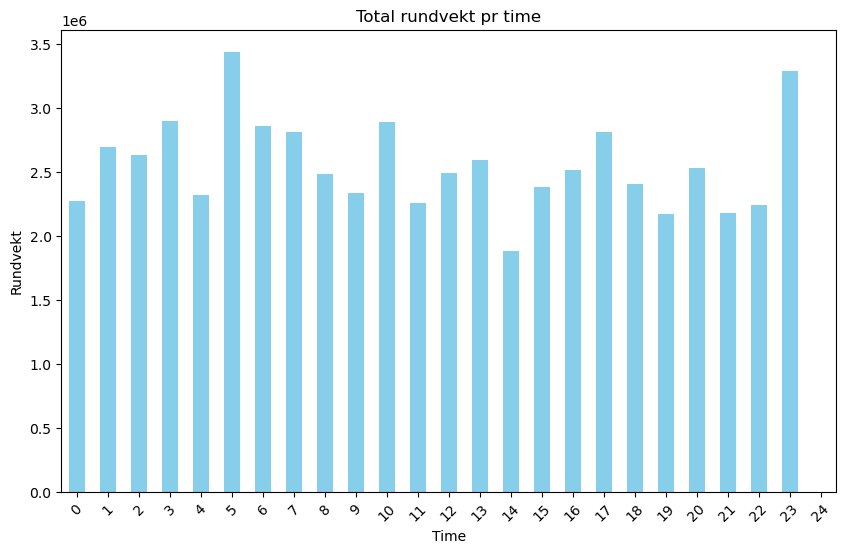

In [288]:
# Regner ut gjenomsnitt pr time
hourly_weights = grouped_df.groupby('Hours')['Rundvekt'].sum()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Total rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

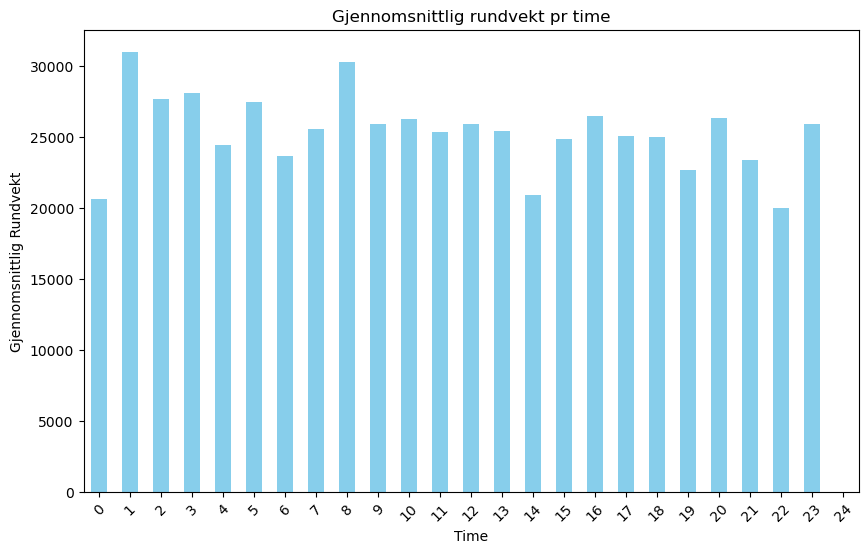

In [289]:
# Regner ut gjenomsnitt pr time
hourly_average = hourly_weights/hourly_counts

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_average.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Gjennomsnittlig Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

### Tolking av data:
Det ser ut som seifisket med bunntrål fordeler seg ganske jevnt ut over døgnet og året, men med litt mer variasjon i løpet av året, og med den beste fangsmåneden i september om man ser på gjennomsnittlig fangst. Om noe forskjell i løpet av døgnet, så ser det ut som det det blir fanget noe mer fisk fra rundt midnatt til og med kl 11. 

Selv om det er lite variasjoner på døgnet, kan er det ikke sikkert dette er helt irrelevant for å predikere fiske. Det kan tenkes at det kan skyldes at fiske i nordlige deler på sommer eller vinterhalvåret gir naturlig en jevnere fordeling ila døgnet, siden forskjellene på natt og dag er mindre. Kanskje ville disse forskjellene være tydeligere i mer sørlige områder.


Om man skal bruke tid på døgnet må vi omforme dataene litt.
Maskinen og modellene vil tolke 00.01 og 23.59, som to verdier som er veldig langt ifra hverandre, ved å omregne til sinus/radian, så kan vi løse dette. Da får vi mer "sykliske" data

In [290]:
grouped_df['Startklokkeslett'] = pd.to_datetime(grouped_df['Startklokkeslett'], format='%H:%M').dt.strftime('%H-%M')
# Konverter til Desimal-timer.
grouped_df['Startklokkeslett_DecimalHours'] = grouped_df['Startklokkeslett'].str.split('-').apply(lambda x: int(x[0]) + int(x[1]) / 60)
# Konverter til Radianer.
grouped_df['Startklokkeslett_Radians'] = grouped_df['Startklokkeslett_DecimalHours'] * (2 * np.pi / 24)
grouped_df.head()

Melding ID Meldingstidspunkt Meldingsdato Meldingsklokkeslett  \
0     1497435  02.01.2018 07:50   2018-01-02               07:50   
1     1497823  02.01.2018 23:31   2018-01-02               23:31   
2     1497827  02.01.2018 23:31   2018-01-02               23:31   
3     1497843  02.01.2018 23:45   2018-01-02               23:45   
4     1497856  02.01.2018 23:54   2018-01-02               23:54   

     Starttidspunkt   Startdato Startklokkeslett  Startposisjon bredde  \
0  01.01.2018 03:21  01.01.2018            03-21                68.256   
1  02.01.2018 00:20  02.01.2018            00-20                68.535   
2  02.01.2018 21:48  02.01.2018            21-48                69.483   
3  02.01.2018 16:52  02.01.2018            16-52                63.122   
4  02.01.2018 12:00  02.01.2018            12-00                61.221   

   Startposisjon lengde  Hovedområde start (kode)  ...  Bruttotonnasje 1969  \
0                10.828                       5.0  ...               2580.0   
1                11.986                       5.0  ...               2580.0   
2                15.850                       5.0  ...                  NaN   
3                 5.381                       7.0  ...                536.0   
4                 2.181                      28.0  ...               2053.0   

  Bruttotonnasje annen Bredde Fartøylengde  Bruttotonnasje kombinert  \
0                  NaN  14.60        64.00                    2580.0   
1                  NaN  14.60        64.00                    2580.0   
2                129.0   7.01        25.07                     129.0   
3                  NaN  10.30        33.95                     536.0   
4                  NaN  13.00        75.50                    2053.0   

   Bruttotonnasje gruppert  Hours  Month  Startklokkeslett_DecimalHours  \
0                        3      3      1                       3.350000   
1                        3      0      1                       0.333333   
2                        1     21      1                      21.800000   
3                        1     16      1                      16.866667   
4                        3     12      1                      12.000000   

  Startklokkeslett_Radians  
0                 0.877028  
1                 0.087266  
2                 5.707227  
3                 4.415683  
4                 3.141593  

[5 rows x 34 columns]

## 6: Slette kolonner:


In [291]:
grouped_df.columns


Index(['Melding ID', 'Meldingstidspunkt', 'Meldingsdato',
       'Meldingsklokkeslett', 'Starttidspunkt', 'Startdato',
       'Startklokkeslett', 'Startposisjon bredde', 'Startposisjon lengde',
       'Hovedområde start (kode)', 'Havdybde start', 'Stopptidspunkt',
       'Stoppdato', 'Stoppklokkeslett', 'Varighet', 'Stopposisjon bredde',
       'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Redskap FDIR',
       'Hovedart FAO', 'Rundvekt', 'Lengdegruppe (kode)', 'Lengdegruppe',
       'Bruttotonnasje 1969', 'Bruttotonnasje annen', 'Bredde', 'Fartøylengde',
       'Bruttotonnasje kombinert', 'Bruttotonnasje gruppert', 'Hours', 'Month',
       'Startklokkeslett_DecimalHours', 'Startklokkeslett_Radians'],
      dtype='object')

In [292]:

# Dropper kolonner: Vi hasher ut de kolonnene vi vil beholde.
grouped_df = grouped_df.drop(columns=[
    'Melding ID', 
    'Meldingstidspunkt', 
    'Meldingsdato', 
    'Meldingsklokkeslett', 
    'Starttidspunkt', 
    'Startdato', 
    'Startklokkeslett', # har konvertert
    #'Startposisjon bredde', 
    #'Startposisjon lengde', 
    'Hovedområde start (kode)', 
    #'Havdybde start', 
    'Stopptidspunkt', # Vi antar at det er liten forskjell på start og sluttidspunkt, så vi velger å droppe disse.
    'Stoppdato', 
    'Stoppklokkeslett', 
    'Varighet', 
    'Stopposisjon bredde', 
    'Stopposisjon lengde', 
    #'Havdybde stopp', Kan være interessant å se på senere
    #'Trekkavstand', 
    #'Redskap FDIR', 
    #'Hovedart - FDIR (kode)', 
    #'Rundvekt', 
    'Lengdegruppe (kode)', 
    'Lengdegruppe', 
    'Bruttotonnasje 1969', 
    'Bruttotonnasje annen', 
    'Bredde', 
    'Fartøylengde', 
    #'Bruttotonnasje kombinert', 
    # Bruttotonnasje gruppert,
    'Hours', 
    #'Month', Tar med måned videre.
    #'Startklokkeslett_DecimalHours',
    #'Startklokkeslett_Radians'
    ])

grouped_df.describe()

Startposisjon bredde  Startposisjon lengde  Havdybde start  \
count           2428.000000           2428.000000     2428.000000   
mean              67.017756             13.584797     -195.379736   
std                4.111731              8.436603       68.759183   
min               60.003000              2.006000     -751.000000   
25%               62.939250              5.368000     -230.000000   
50%               69.400000             15.767000     -187.000000   
75%               70.870250             20.690250     -154.000000   
max               71.998000             32.279000        1.000000   

       Havdybde stopp   Trekkavstand       Rundvekt  Bruttotonnasje kombinert  \
count     2428.000000    2428.000000    2428.000000               2428.000000   
mean      -198.379736   13838.107084   25286.696458               1953.747941   
std         75.965229   11677.512915   19471.572679               1153.536451   
min      -1276.000000       0.000000      10.000000                129.000000   
25%       -233.000000    5128.750000    9082.500000               1194.000000   
50%       -188.000000   10272.000000   21738.500000               1648.000000   
75%       -151.750000   19442.750000   37226.750000               3104.000000   
max        -49.000000  138228.000000  117858.000000               4427.000000   

             Month  Startklokkeslett_DecimalHours  Startklokkeslett_Radians  
count  2428.000000                    2428.000000               2428.000000  
mean      5.982702                      12.031652                  3.149879  
std       3.475933                       7.028280                  1.839999  
min       1.000000                       0.000000                  0.000000  
25%       3.000000                       5.933333                  1.553343  
50%       6.000000                      11.966667                  3.132866  
75%       9.000000                      18.120833                  4.744023  
max      12.000000                      23.966667                  6.274459

## 7: rense nullverdier og ekstremer
Nullverdier.

Av df.describe leser vi først max og min verdier for å se om det er noen ekstreme eller usannsynlige verdier.
Rundvekt, 0 - registreringer. Ser at det er registreringer med verdien 0 i trekkavstand og rundvektkolonnen. Vi anser dette som feilregistreringer. Av trålens natur, at den soper store havområder, ser vi det som lite trolig at rundvekt 0 skal forekomme. Videre kan vi anta at registreringer med 0 i trekkavstand også er lite sannsynlig. 

Trekkavstand:
Vi ser at det ligger registreringer på over 200000 meter, det vil si 200 km eller 20 mil. Dette er store avstander for en trål som vanligvis opererer i snittfart på mellom 3,4 (6,3km/h) og 5 knop (9,26 km/h). I en snittfart på 10km/h så vil da trålen bruke over 20 timer. Med så lang varighet vil det være svært ugunstige forhold for fisken. 
Vi ser også at 5% av registreringene er over 35446m. Her ser vi også at med relativt høy fart, vil aktiviteten ha varighet på nærmere 4 timer. Ved å kutte registreringer over 50000 gir det oss en god margin på mulige feilregistreringer.

Dybde:
Vi ser det er registrert positive havdybde-verdier, i tillegg er det også registrert aktiviteter på -1276 dybde. Men de aller fleste aktivitetene er registrert mellom -227 og -145 meter. Fiskeridirektoratet beskriver at "Sei førekjem både pelagisk og som botnfisk, frå 0 til 300 meters djup." (https://www.hi.no/hi/temasider/arter/nordaustarktisk-sei) Vi mener det er sannsynlig at dette er enten en feilregistrering eller at fangsten er gjort når trålen er på vei opp av dypet. 



Ser av trekkavstand at det i 0-registreringene av trekkavstand også fanges fisk. Dette gir ikke mening med tanke på at det følgelig må trekkes en viss avstand for å få fisk.

Ser også her at det er registrert forskjellige arter i 0-registrerningene på rundvekt. Det er da fornuftig å anta at dette enten er feilregistreringer eller fangst uten betydning.

In [293]:
print(grouped_df.info())
print(grouped_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2428 entries, 0 to 2427
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startposisjon bredde           2428 non-null   float64 
 1   Startposisjon lengde           2428 non-null   float64 
 2   Havdybde start                 2428 non-null   int64   
 3   Havdybde stopp                 2428 non-null   int64   
 4   Trekkavstand                   2428 non-null   float64 
 5   Redskap FDIR                   2428 non-null   object  
 6   Hovedart FAO                   2428 non-null   object  
 7   Rundvekt                       2428 non-null   float64 
 8   Bruttotonnasje kombinert       2428 non-null   float64 
 9   Bruttotonnasje gruppert        2349 non-null   category
 10  Month                          2428 non-null   int32   
 11  Startklokkeslett_DecimalHours  2428 non-null   float64 
 12  Startklokkeslett_Radians       242

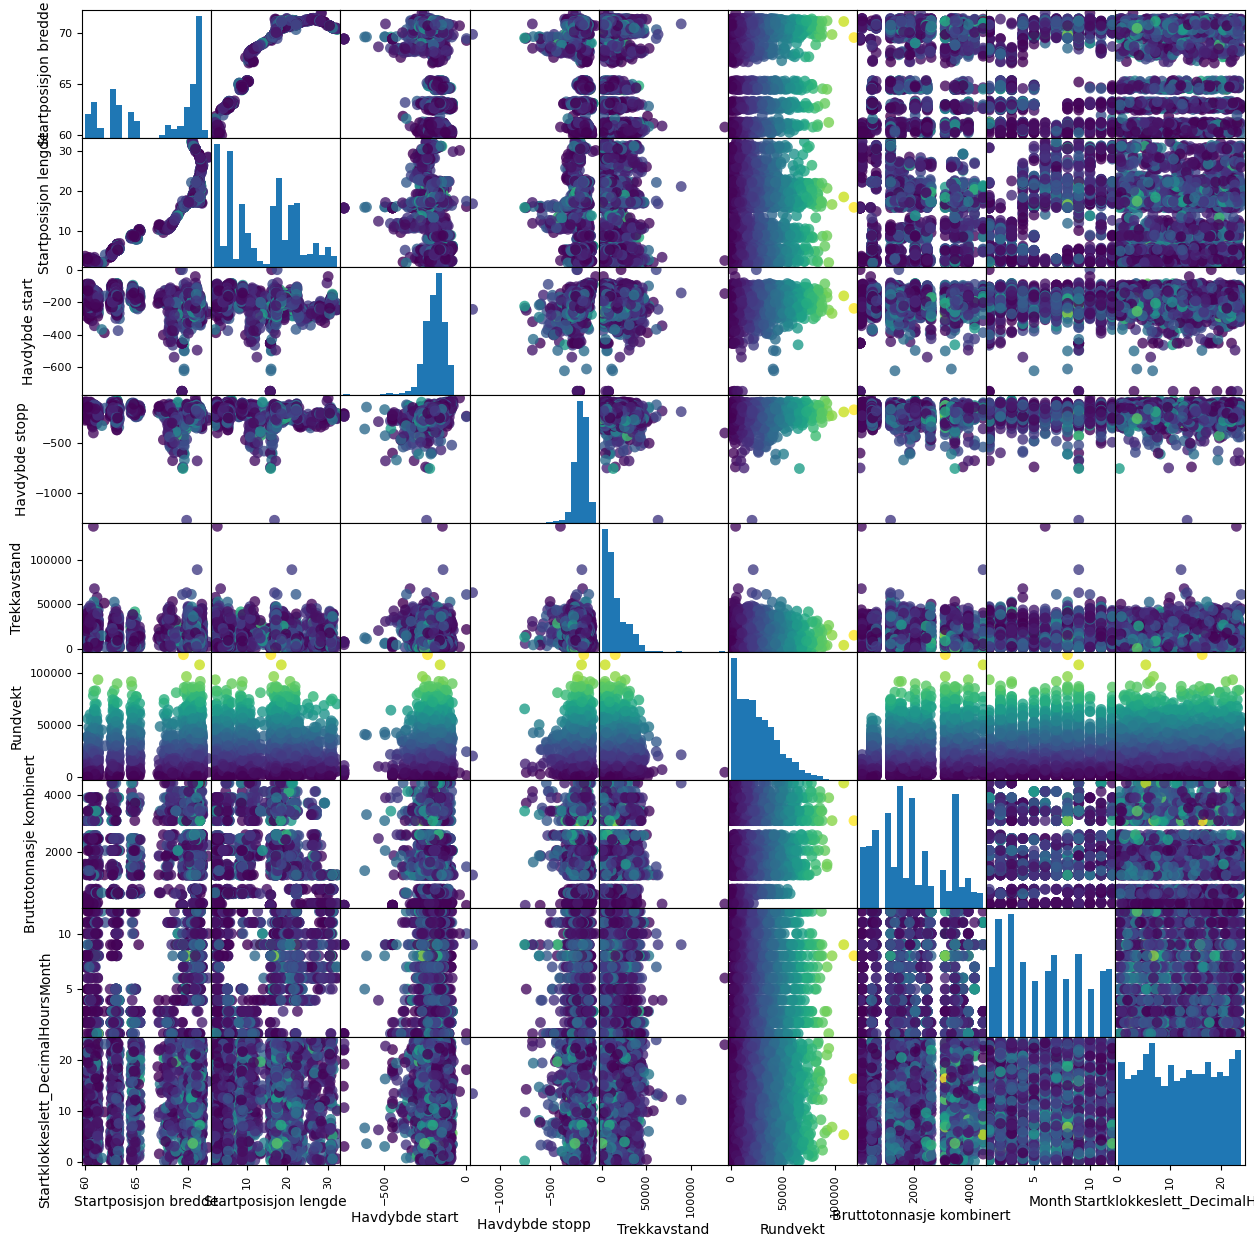

In [294]:
# Inkluderer de numeriske kolonnene
numeric_columns = ['Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
       'Havdybde stopp', 'Trekkavstand', 'Rundvekt', 'Bruttotonnasje kombinert',
       'Month', 'Startklokkeslett_DecimalHours']
plot_frame = grouped_df[numeric_columns]  

# Genererer scatter matrix plot
grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8
    )

Ser av dette at det er noen ekstreme verdier.
Havdybdekolonnene kan vi konvertere til positive verdier + fjerne ekstremer. Lite sannsynlig at seifiske foregår på under 5-600 meter. Kan være tastefeil.
Trekkavstand ser ut til å ha en del usannsynlige verdier.
Vurdere å fjerne ekstremverdier fra rundvekt. Vi tenker det kan være lurt å slette registreringer med 0 i rundvekt, da det lite trolig er registrert aktiviteter hvor det er fanget fisk, men vekten er 0 kg.



In [295]:
# Fjerner radene med data nevnt over:
# Droppe tomme rader.
cleaned_df = grouped_df.copy().dropna()
# Konvertere positive Havdybdeverdier
cleaned_df['Havdybde stopp'] = cleaned_df['Havdybde stopp'].abs()
cleaned_df['Havdybde start'] = cleaned_df['Havdybde start'].abs()
# fjerne havdybder over 700
cleaned_df = cleaned_df[cleaned_df['Havdybde stopp'] < 500]
cleaned_df = cleaned_df[cleaned_df['Havdybde start'] < 500]
# Ta vekk havdybder på over 10 m, for å fjerne usannsynlige tråledybder.
cleaned_df = cleaned_df[cleaned_df['Havdybde stopp'] > 10]
# Droppe trekkavstand på over 50000 m.
cleaned_df = cleaned_df[(cleaned_df['Trekkavstand'] > 0) & (cleaned_df['Trekkavstand'] < 50000)]
# Droppe Rundvekt med nullverdier:
cleaned_df = cleaned_df[cleaned_df['Rundvekt'] > 0]
# Droppe rundvekt med registreringer over 115000
cleaned_df = cleaned_df[cleaned_df['Rundvekt'] < 115000]


# Droppe ekstreme Bruttotonnasjeverdier.
cleaned_df = cleaned_df[(cleaned_df['Bruttotonnasje kombinert'] > 400) & (cleaned_df['Bruttotonnasje kombinert'] < 4000)]
# Droppe registreringer i områder som ikkje er i Norsk farvatn. Startposisjon med mindre enn 0.
cleaned_df = cleaned_df[cleaned_df['Startposisjon lengde'] > 0]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163 entries, 1 to 2427
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startposisjon bredde           2163 non-null   float64 
 1   Startposisjon lengde           2163 non-null   float64 
 2   Havdybde start                 2163 non-null   int64   
 3   Havdybde stopp                 2163 non-null   int64   
 4   Trekkavstand                   2163 non-null   float64 
 5   Redskap FDIR                   2163 non-null   object  
 6   Hovedart FAO                   2163 non-null   object  
 7   Rundvekt                       2163 non-null   float64 
 8   Bruttotonnasje kombinert       2163 non-null   float64 
 9   Bruttotonnasje gruppert        2163 non-null   category
 10  Month                          2163 non-null   int32   
 11  Startklokkeslett_DecimalHours  2163 non-null   float64 
 12  Startklokkeslett_Radians       2163 non

Endre format på kolonnene til riktig format:
Her ser vi at 

Ser av value_counts at de mest vanlige redskapene er bunntrål og snurrevad. Her er det så mye data at vi fokuserer videre på dette. (Usikker på å inkludere snurrevad.

df['Redskap

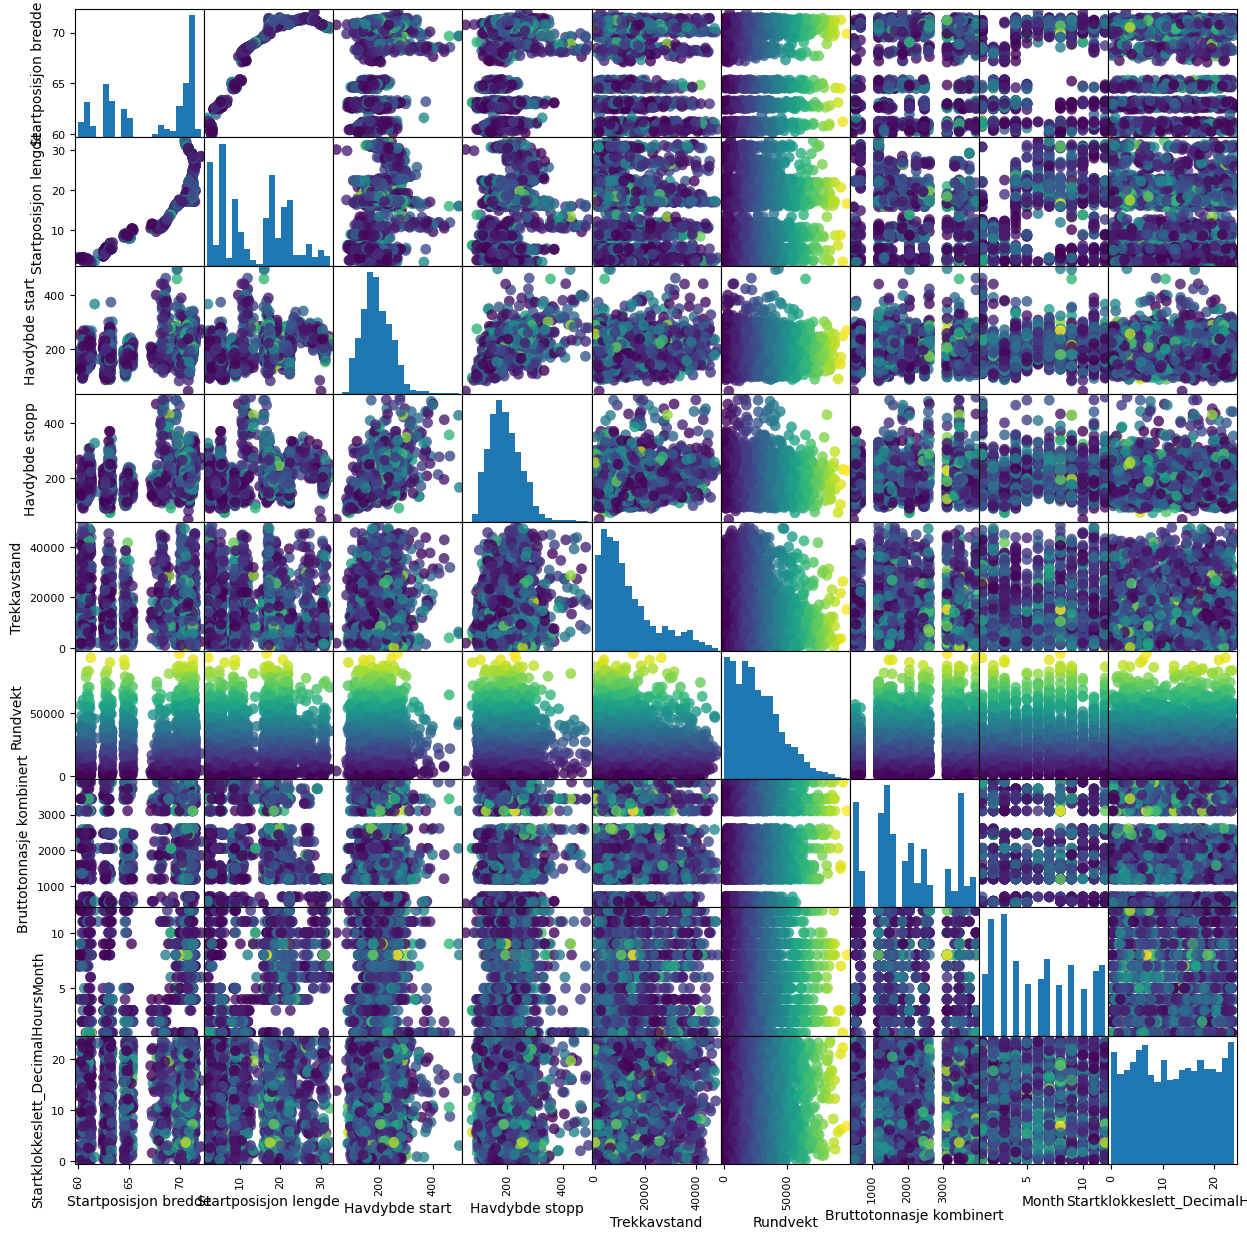

In [296]:
plot_frame = cleaned_df[numeric_columns]  # Append 'Rundvekt' to include it in the DataFrame for plotting

# Generate the scatter matrix plot
grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8
    )

### Dimensionality reduction:
from sklearn.decomposition import PCA

In [297]:
from sklearn.decomposition import PCA
# Normalize the data
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(cleaned_df[['Startposisjon lengde', 'Startposisjon bredde']])

# Apply PCA
pca = PCA(n_components=1)
cleaned_df['position'] = pca.fit_transform(coords_scaled)

month_time_scaled = scaler.fit_transform(cleaned_df[['Month', 'Startklokkeslett_Radians']])
# Konvertere måned og time - Med tanke på at det kanskje er sammenheng mellom beste klokkeslett og når på året en fisker. 
# For eksempel på vinter er det mørkere, og det kan kanskje påvirke ideelle tidspunkt for fiske:
cleaned_df['Month/time'] = pca.fit_transform(month_time_scaled)

In [298]:
from sklearn.cluster import KMeans  # Vurdere å droppe dette

# Assuming you've already scaled latitude and longitude
kmeans = KMeans(n_clusters=5)  # Adjust clusters based on domain knowledge
cleaned_df['location_cluster'] = kmeans.fit_predict(cleaned_df[['Startposisjon bredde', 'Startposisjon lengde']])


/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [299]:
# Lager kolonne som tar ser om trålen dras i oppoverbakke eller nedoverbakke.
cleaned_df['Havdybde differanse'] = cleaned_df['Havdybde start'].abs()-cleaned_df['Havdybde stopp']
cleaned_df = cleaned_df[(cleaned_df['Havdybde differanse'] > -150) & (cleaned_df['Havdybde differanse'] < 150)]


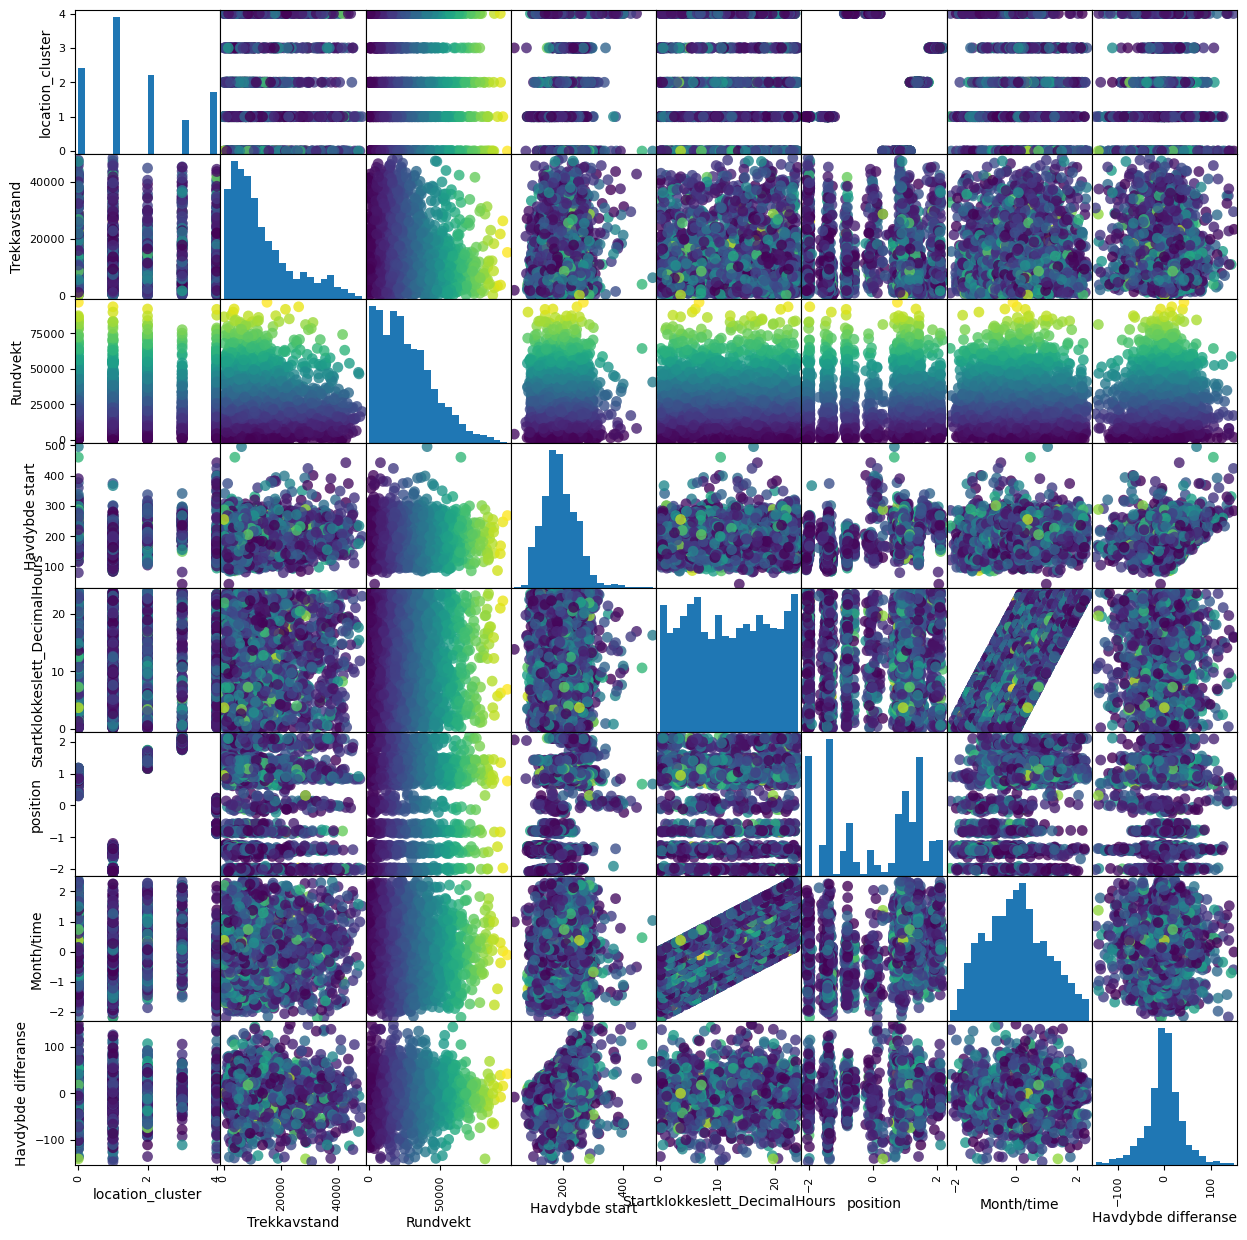

In [300]:
features = ['location_cluster', 'Trekkavstand', 'Rundvekt', 'Havdybde start', 'Startklokkeslett_DecimalHours', 'position', 'Month/time', 'Havdybde differanse']
plot_frame = cleaned_df[features]  # Append 'Rundvekt' to include it in the DataFrame for plotting

# Generate the scatter matrix plot
grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8
)

# 2: Supervised learning

## 2.1: KNN
Vi har valgt å prøve KNNClassifier, for å klassifisere fangsten. Når vi bruker en klassifiseringsmodell. Vi vil prøve å skalere dataene.

Det 

In [301]:
# printer litt info om kolonnene
print(cleaned_df.columns)
print(cleaned_df.info())

Index(['Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
       'Havdybde stopp', 'Trekkavstand', 'Redskap FDIR', 'Hovedart FAO',
       'Rundvekt', 'Bruttotonnasje kombinert', 'Bruttotonnasje gruppert',
       'Month', 'Startklokkeslett_DecimalHours', 'Startklokkeslett_Radians',
       'position', 'Month/time', 'location_cluster', 'Havdybde differanse'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 2124 entries, 1 to 2427
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startposisjon bredde           2124 non-null   float64 
 1   Startposisjon lengde           2124 non-null   float64 
 2   Havdybde start                 2124 non-null   int64   
 3   Havdybde stopp                 2124 non-null   int64   
 4   Trekkavstand                   2124 non-null   float64 
 5   Redskap FDIR                   2124 non-null   object  
 6   Hovedart 

In [322]:
# Velger aktuelle features:
selected_features = [
    'Trekkavstand',
    'Bruttotonnasje kombinert', 
    'position', 
    'Month/time',
    'Havdybde differanse',
    'Havdybde start'
    ]
# Kan ikke bruke rundvekt som target i knn-classifier, så vi må konvertere til kategorisk data.
target = ['Rundvekt']


Q-binning av rundvekt

In [323]:
# Grupperer rundvekt i fire kategorier, for at den skal kunne brukes med kNN-klassifier
labels = ['bad catch', 'Below Average', 'Above average', 'Good catch']

num_bins = 4  # Antall grupper
labels = ['Q1', 'Q2', 'Q3', 'Q4']  # lager fire grupper
cleaned_df['Q-binned'] = pd.qcut(cleaned_df['Rundvekt'], q=num_bins, labels=labels)
cleaned_df['Q-binned'].value_counts()

Q-binned
Q1    531
Q2    531
Q3    531
Q4    531
Name: count, dtype: int64

In [324]:
# Kalkulerer gjennomsnittsrundvekten.
mean_catch_weight = cleaned_df['Rundvekt'].mean()
# Finner standardavviket.
std_dev_catch_weight = cleaned_df['Rundvekt'].std()

# Definerer bins, basert på standardavvik.
lower_bound = mean_catch_weight - std_dev_catch_weight
upper_bound = mean_catch_weight + std_dev_catch_weight

cleaned_df['std-binned'] = pd.cut(cleaned_df['Rundvekt'], 
                                      bins=[-np.inf, lower_bound, mean_catch_weight, upper_bound, np.inf], 
                                      labels=labels)

print('Standardfordeling:', std_dev_catch_weight)
print('Gjennomsnittsfangst:', mean_catch_weight)

# Display the first few rows to verify the binning
cleaned_df[['std-binned']].value_counts()

Standardfordeling: 19088.742228529798
Gjennomsnittsfangst: 26528.957627118645


std-binned
Q2            827
Q3            588
Q1            366
Q4            343
Name: count, dtype: int64

### Scaling
#### Min-max
prøver ut Min-max på Q-binned

In [325]:
# Setter target til Q-binned.
target = 'Q-binned'

X = cleaned_df[selected_features]
y = cleaned_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  


In [326]:
# Scale features (for kNN)
scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [327]:
# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train_encoded)
y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
print(f"KNN Classifier Score: {accuracy}")


KNN Classifier Score: 0.32941176470588235


#### Standardscaler:
Forsøker på nytt med standardscaler

In [328]:
# Skalerer
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train_encoded)
y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
print(f"KNN Classifier Score: {accuracy}")

KNN Classifier Score: 0.2917647058823529


Ser at Min-max scorer noe bedre enn standardscaler

#### Tester std-binned target
Tester standardfordelte grupper for målverdi:

In [331]:
# Setter target til std-fordelt gruppering std-binned.
new_target = 'std-binned'

# Setter scaler tilbake til min-max
scaler = MinMaxScaler(feature_range=(0,1))
X = cleaned_df[selected_features]
y = cleaned_df[new_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [334]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train_encoded)
y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
print(f"KNN Classifier Accuracy: {accuracy}")
print(f'kNN Classifier Score {knn_classifier.score(X_test_scaled, y_test_encoded)}')

KNN Classifier Accuracy: 0.37411764705882355
kNN Classifier Score 0.37411764705882355


Tolking av resultat:
Ser ut som standardfordelt gruppering av målverdier gir bedre resultat

In [337]:
# Genererer en dictionary med parameterene vi vil tune. Hvor mange naboer, algoritme, 
# Hvordan modellen vektlegger og hvordan modellen regner avstand.
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

# Genererer gridsearch-objekt
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# fitting.
grid_search.fit(X_train_scaled, y_train_encoded)

# Finner beste resultat
best_knn = grid_search.best_estimator_

# Predikerer ved bruk av beste modell.
y_pred = best_knn.predict(X_test_scaled)

# Skriver ut score.
accuracy = accuracy_score(y_test_encoded, y_pred)
print(
    f'Beste kNN Classifier Score med :\n Naboer: {best_knn.n_neighbors}\n Vekter: "{best_knn.weights}"\n Metric: "{best_knn.metric}"\n Algoritme: "{best_knn.algorithm}"\nNøyaktighet: "{accuracy}"'
      )

Beste kNN Classifier Score med :
 Naboer: 10
 Vekter: "uniform"
 Metric: "manhattan"
 Algoritme: "ball_tree"
Nøyaktighet: "0.3623529411764706"


Dette Ble et ennå bedre resultat. 
Et resultat på ________ er, tatt i betraktning usikkerheten rundt fiskeriets natur et godt resultat.
Vi finjusterer parametrene med grid search:

Desiscion tree

In [312]:
from sklearn.metrics import mean_absolute_error
# Endrer til rundvekt for flytende tallverdier.

target = 'Rundvekt'
y = cleaned_df[target]
# Splitter settet i trainsett og testsett - Da kan man sammenligne prediksjonene mot et test-sett
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
# Velger MLmodell
fishery_model = DecisionTreeRegressor(random_state=1)
# Trener(?) modellen på train-settet

fishery_model.fit(X_train, y_train)
# Prediksjoner - predikerer tar X-val verdiene og predikerer rundvekt basert på disse tallene.
val_predictions = fishery_model.predict(X_val)
# Sammenligner et utvalg (X-val.head()) av prediksjoner mot relaterte y_val.head()
print(fishery_model.predict(X_val.head()))
print(y_val.head())

# Tar inn y_val verdiene og regner ut gjennomsnittlig feil mellom prediksjonene og test-verdiene(val_y)
val_mae = mean_absolute_error(y_val, val_predictions)
print(f'\nMean absolute error: {val_mae}')
print(f'\nScore: {fishery_model.score(X_val, y_val)}\n')

[24443. 14972. 11819. 20230. 15905.]
1600    24796.0
2363    24384.0
961     20098.0
1924    10007.0
712     38977.0
Name: Rundvekt, dtype: float64

Mean absolute error: 18883.809411764705

Score: -0.6394883105320404



## 2.3: Linear regression:


In [313]:
data = cleaned_df[features]
predict = 'Rundvekt'

y = cleaned_df[predict]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)
score = linear.score(x_test, y_test)
print(score)

0.09166138389184464


## 2.4: MLP regressor


In [314]:
#Columns removed for training of MLPRegressor neural network
# 'Meldingstidspunkt',
# 'Starttidspunkt',
# 'Startklokkeslett',
# 'Stopptidspunkt',
# 'Art - FDIR',
# 'Melding ID',
# 'Havdybde start',# Filter and remove incorrect values
# 'Havdybde stopp',# Filter and remove incorrect values
# 'Redskap FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
# #  'Bruttotonnasje Kombinert',
# 'Hovedart - FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
# 'Art - FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
# 'Art - gruppe (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi

# Gruppere bruttotonnasje:
bins = [x for x in range(0, 4800, 100)] # Definerer gruppene
labels = range(1, len(bins))  # nummererer gruppene.
# Categorize 'Bruttotonnasje Kombinert' into the defined bins
cleaned_df['Bruttotonnasje Gruppert'] = pd.cut(cleaned_df['Bruttotonnasje kombinert'], bins=bins, labels=labels)
# Teller grupperingene
cleaned_df['Bruttotonnasje Gruppert'].value_counts()

Bruttotonnasje Gruppert
6     250
12    234
35    232
15    201
21    158
25    144
19    113
16    104
14    102
32     95
7      91
17     74
40     72
23     60
38     52
36     42
34     41
27     26
26     25
5       8
37      0
1       0
39      0
41      0
42      0
43      0
44      0
45      0
46      0
33      0
24      0
31      0
30      0
29      0
28      0
2       0
22      0
20      0
18      0
13      0
11      0
10      0
9       0
8       0
4       0
3       0
47      0
Name: count, dtype: int64

In [315]:
print(cleaned_df.shape)
cleaned_df.head()
y = cleaned_df['Rundvekt'] 
X = cleaned_df.drop('Rundvekt', axis=1) #Dropping rundvekt since that's what i'm training the model on


(2124, 20)


In [316]:
from sklearn.datasets import make_regression
# X = df.drop('Rundvekt', axis=1)
# y = df['Rundvekt']
X, y = make_regression(n_samples=200, random_state=1) #Might make it overfit!
# print(X,y)

In [317]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 1235)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [318]:
#MinMax Scaler works best with MLPRegressor

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.fit_transform(X_test)

# print(X)

In [319]:
#Turns out standard scaler does horrible tings to MLPregressor! it does best with values between 0 and 1

# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()

# scaler = sc.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [320]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes = [20,10], #First hidden layer has 20 neurons, second hidden layer has 10 neurons
                  activation = 'relu', alpha = 0.1, 
                  max_iter = 2000, #Max iterations you do. AKA max epocs
                #   early_stopping=True, #Can't use early stopping due to massive loss values in Rundvekt
                #   tol=
                  learning_rate_init=0.1,#Initial learning rate, adaptive adapts this learning rate to minimize loss
                  learning_rate="adaptive",
                  solver = 'adam', 
                  verbose = False)
#activation logistic tanh relu identity
#solver adam lbfgs sgd 

In [321]:
#Test score without data leak. (using minmax after splitting)
# nn.fit(X_train, y_train)
nn.fit(X_train_minmax, y_train)
print("Neural network, MLPRegressor")
print("Test score",  nn.score(X_test_minmax, y_test))
print("Train  score", nn.score(X_train_minmax, y_train)) #Fix training score, might be wrong due to testing on training data


# print("Neural network, MLPRegressor")
# print("Test score",  nn.score(X_test, y_test))
# print("Train  score", nn.score(X_train, y_train)) #Fix training score, might be wrong due to testing on training data

# print("FIXED???? Neural network, MLPRegressor")
# print("Test score",  nn.score(X_test_scaled, y_test))
# print("Train  score", nn.score(X_train_scaled, y_train)) #Fix training score, might be wrong due to testing on training data

Neural network, MLPRegressor
Test score 0.6051204924550826
Train  score 0.8947800148467833


Oppsummering: https://stackoverflow.com/questions/62131266/mlpregressor-working-but-results-dont-make-any-sense It doesn't make any sense to predict on your training data. That provides no value, as it is testing the same data it learned from and should predict 100%. That is an example of

important and relevant properties of the data how you preprocessed data like which features you selected, did you do dimension reduction, how you reformatted data, etc. how you decided on parameters for your machine learning models, if you used any regularization techniques? In case how. how the methods were measured and compared

Turns out trying a max_iter of 1000 was a bit dumb! It wasnt enough iterations for the model to become optimized (converge) To fix it i changed max_iter to 5000 and realized that max_iter isn't the amount of iterations you do! it's the max amount of iterations you do. I feel dumb Iterations will be 5000 unless stated otherwise

With 5000 max iterations Test score 0.15868380817426364 Train score 0.2402524144823477

With 1000 max iterations Test score 0.023895760424976542 Train score 0.044879597360761636

Test 2 removed 'Redskap FDIR (kode)', 'Bruttotonnasje Kombinert', Test score 0.22802640821841036 Train score 0.17609209269226367 Eval: Turns out bruttotonnasje is important for amount of fish caught. I can't say i'm surprised

Test 3 max_iter = 10 000 Re-added 'Bruttotonnasje Kombinert' Kept 'Redskap FDIR (kode)' Turns out 5000 iterations wasn't enough! this will hopefully mean we have a smaller loss value and can thus get a higher accuracy as it converges better! Changed to 10 000 iterations max Test score 0.2183750907000509 Train score 0.22780564641998635 The training score seems to have increased! Running it again made Test score = 0.15405352930651073. Removing it seems to cause instability. i will keep it for now

Test 3 added a regression thingy and increased to 100 000 iterations (can probobaly lower it to 10 000 now) Test score 0.3805415453308878 Train score 0.9885294076382664 Obviously overtrained! but the test score is getting better!

Test 4 Fjernet: Hovedart - FDIR (kode) Art - FDIR (kode) Art - gruppe (kode) Dette er grunnet at disse verdiene ikke gav mye unik informasjon å lære fra.

Test score 0.4551050579085447 Train score 0.9926394850239878 Minimal økning, det var i alle fall ingen nedtur i nøyaktigheten. men den er enda overfitted

Max_iter = 1000 removed: Melding ID Test score 0.038746802791864265 Train score 0.04016411056751845

Max_iter = 1000 Test score 0.02857554746080171 Train score 0.04388748121910424 Changing iter to 1000 with a good score is the goal!

V2, removed linear regression thingy Max_iter = 5000 Test score 0.18474766635857465 Train score 0.26563262873718185

Without removed collumns Test score 0.03306077219837722 Train score 0.07260871122128132

with removed collumnds (linear regression collumns) Test score 0.034291607331412455 Train score 0.07651381759634102

# 3: Unsupervised learning
